# Домашнее задание по обработке текстов

## Предсказание цены акции по экономическим новостям

Входные данные:
* Новости о компании "Газпром", начиная с 2010 года
* Стоимость акций компании "Газпром" на ММВБ, начиная с 2010 года
    * цена открытия (Open)
    * цена закрытия (ClosingPrice)
    * максимальная цена за день (DailyHigh)
    * минимальная цена за день (DailyLow) 
    * объем бумаг (VolumePcs)


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#импортируем данные с переводом текста в дату и разделения десятичной части запятой.
#в качестве индекса удобно использовать дату
df = pd.read_csv('texts.csv', parse_dates=[0], index_col=0, converters={1:lambda x: x.replace('\xa0', ' ')})
pr_all = pd.read_csv('gazprom_prices.csv', sep=';', parse_dates=[0], decimal=',', index_col=0)

In [3]:
#Оставляем только даты, когда были и новости и данные по стоимости акций
df = df[df.index.isin(pr_all.index)]
pr_all = pr_all[pr_all.index.isin(df.index)]

In [4]:
#Итого получаем дней для анализа:
len(df)

1159

In [5]:
df.head(), pr_all.head()

(                                                         text
 date                                                         
 2017-09-11  Компания рассчитывает на решение по газовому с...
 2017-08-11   Как и предполагал “Ъ”, «Газпром», воспользова...
 2017-01-11   Новая редакция американских санкций ставит по...
 2017-10-30   Как стало известно “Ъ”, известный на рынке ри...
 2017-10-23   НОВАТЭК, который через пять лет собирается за...,
               Open  ClosingPrice  DailyHigh  DailyLow  VolumePcs
 Date                                                            
 2017-09-11  132.31        131.50     132.82    131.14   33869650
 2017-08-11  132.00        132.30     133.94    131.58   39381960
 2017-01-11  126.40        126.50     126.89    125.97   18232550
 2017-10-30  125.96        125.98     126.93    125.53   19263340
 2017-10-23  127.05        126.80     127.47    126.37   17308800)

### Часть 1. Вводная

Проведите предобработку текстов: если считаете нужным, выполните токенизацию, приведение к нижнему регистру, лемматизацию и/или стемминг. Ответьте на следующие вопросы:
* Есть ли корреляция между средней длинной текста за день и ценой закрытия?
* Есть ли корреляция между количеством упоминаний Алексея Миллера  и ценой закрытия? Учтите разные варианты написания имени.
* Упоминаний какого газопровода в статьях больше: 
    * "северный поток"
    * "турецкий поток"?
* О каких санкциях пишут в статьях?

##### Есть ли корреляция между средней длинной текста за день и ценой закрытия?##### 

In [6]:
#Посчитаем длинну новостей
df['text_len'] = df['text'].apply(len)

In [7]:
np.corrcoef(pr_all.ClosingPrice, df.text_len)[0,1]

0.014409399726613269

Коэффициент корреляции Пирсона меньше 0.3 
**Вывод:** корреляция слабая или отсутствует

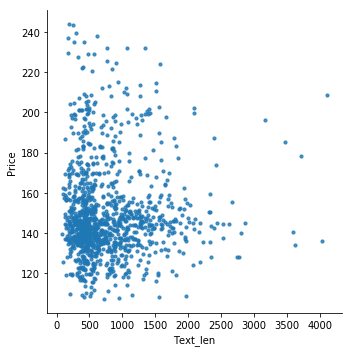

In [8]:
#Построим график для наглядности
corr = pd.DataFrame()
corr['Text_len']=df.text_len
corr['Price']=pr_all.ClosingPrice
sns.lmplot('Text_len',
           'Price', 
           data=corr, 
           fit_reg=False, 
           scatter_kws={"marker": "D", 
                        "s": 10}) 

#### Есть ли корреляция между количеством упоминаний Алексея Миллера и ценой закрытия? #### 

In [9]:
#Посчитаем количество упоминаний Алексея Миллера в новостях.
df['Miller']=df['text'].apply(lambda text: len(re.findall('[Мм]иллер', text)))

In [10]:
np.corrcoef(pr_all.ClosingPrice, df.Miller)[0,1]

0.010635076467578011

Коэффициент корреляции Пирсона меньше 0.3 **Вывод**: корреляция слабая или отсутствует

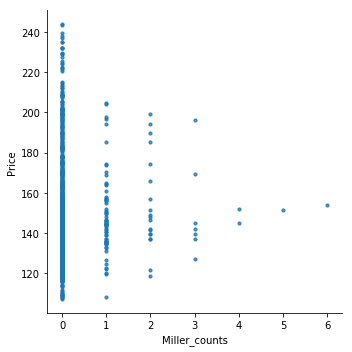

In [11]:
#Построим график для наглядности
m_corr = pd.DataFrame()
m_corr['Miller_counts']=df.Miller
m_corr['Price']=pr_all.ClosingPrice
sns.lmplot('Miller_counts',
           'Price', 
           data=m_corr, 
           fit_reg=False, 
           scatter_kws={"marker": "D", 
                        "s": 10}) 

#### Упоминаний какого газопровода в статьях больше?

In [12]:
#Загрузим данные еще раз, чтобы иметь новости за все даты
df1 = pd.read_csv('texts.csv', parse_dates=[0], index_col=0, converters={1:lambda x: x.replace('\xa0', ' ')})

north = sum(df1['text'].apply(lambda text: len(re.findall('[Сс]еверн[а-я]{2,4} [Пп]оток[а-я]{0,3}', text))))
turkish = sum(df1['text'].apply(lambda text: len(re.findall('[Тт]урецк[а-я]{2,4} [Пп]оток[а-я]{0,3}', text))))
print("Упоминаний Турецкого потока: {}\nУпоминаний Северного потока: {}".format(turkish,north))

Упоминаний Турецкого потока: 39
Упоминаний Северного потока: 15


#### О каких санкциях пишут в статьях?

In [13]:
#Лемматизация
from pymorphy2 import MorphAnalyzer

def lem(text):
    m =  MorphAnalyzer()
    return  [m.parse(word)[0].normal_form for word in text.split()]

df1['lemmas']=df1['text'].apply(lem)

In [14]:
#Оставим только новости о санкциях
sanctions = df1['lemmas'][df1['lemmas'].apply(lambda x: 'санкция' in x)]

In [15]:
#Функция для поиска прилагательных перед словом "санкция"
def sanc_a(text):
    m= MorphAnalyzer()
    word_index = [i-1 for i, x in enumerate(text) if x == "санкция"]
    adj = []
    for i in word_index:
        if m.parse(text[i])[0].tag.POS in ['ADJF', 'ADJS']:
            adj.append(text[i])
    return adj

In [16]:
set(sum(sanctions.apply(sanc_a)))

{'американский',
 'западный',
 'персональный',
 'секторальный',
 'штрафной',
 'экономический'}

В списке выше можно видеть о каких санкциях идет речь в новостях.

## Часть 2. Классификационная
Вам предстоит решить следующую задачу: по текстам новостей за день определить, вырастет или понизится цена закрытия.
Для этого:
* бинаризуйте признак "цена закрытия":  новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случаея;
* составьте бучающее и тестовое множество: данные до начала 2016 года используются для обучения, данные с 2016 года и позже – для тестирования.

Таким образом, в каждлый момент времени мы знаем: 
* ClosingPrice_bin – бинарый целевой признак
* слова из статей, опубликованных в этот день – объясняющие признаки

В этой части задания вам нужно сделать baseline алгоритм и попытаться его улучшить в следующей части. 

Используйте любой известный вам алгоритм классификации текстов для того, Используйте $tf-idf$ преобразование, сингулярное разложение, нормировку признакого пространства и любые другие техники обработки данных, которые вы считаете нужным. Используйте accuracy и F-measure для оценки качества классификации. Покажите, как  $tf-idf$ преобразование или сингулярное разложение или любая другая использованная вами техника влияет на качество классификации.
Если у выбранного вами алгоритма есть гиперпараметры (например, $\alpha$ в преобразовании Лапласа для метода наивного Байеса), покажите, как изменение гиперпараметра влияет на качество классификации.

#### Бинаризуйте признак "цена закрытия": новый признак ClosingPrice_bin равен 1, если по сравнению со вчера цена не упала, и 0 – в обратном случае#### 

In [33]:
pr_all['ClosingPrice_bin'] = pr_all.ClosingPrice >= pr_all.ClosingPrice.shift()
pr_all['ClosingPrice_bin'] = pr_all['ClosingPrice_bin'].apply(lambda x: 1 if x == True else 0)
pr_all.head()

,Open,ClosingPrice,DailyHigh,DailyLow,VolumePcs,ClosingPrice_bin
Date,,,,,,
2017-09-11,132.31,131.50,132.82,131.14,33869650,0
2017-08-11,132.00,132.30,133.94,131.58,39381960,1
2017-01-11,126.40,126.50,126.89,125.97,18232550,0
2017-10-30,125.96,125.98,126.93,125.53,19263340,0
2017-10-23,127.05,126.80,127.47,126.37,17308800,1


In [35]:
#Добавим леммы в обрезанную выборку
df['lemmas']=df1['lemmas'][df1.index.isin(df.index)]

In [44]:
#Функция разбивки данных на обучающую и тестовую выборки
def train_test_split_custom(X, y, year):
    X_train = X[X.index.year < year]
    X_test = X[X.index.year >= year]
    y_train = y[y.index.isin(X_train.index)]
    y_test = y[y.index.isin(X_test.index)]
    return X_train, X_test, y_train, y_test

In [75]:
X = df['lemmas'].apply(" ".join)
y = pr_all['ClosingPrice_bin']
X_train, X_test, y_train, y_test = train_test_split_custom(X, y, 2016)

In [83]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import *
from sklearn.metrics import *
from sklearn.pipeline import Pipeline

In [ ]:
stop_words = stopwords.words('russian')

## Используем RandomForest без tf-idf

### Остальные параметры заранее подобраны для наибольшей точности

In [241]:
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2), stop_words=stop_words)),
    #('tfidf', TfidfTransformer()),
    ('reducer', TruncatedSVD(n_components=30)),
    ('clf', RandomForestClassifier(random_state=0, n_estimators=100)),
])


clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['и', 'в', ...stimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [242]:
predictions = clf.predict(X_test)

Precision:   0.50
Recall:   0.50
F1-measure:   0.50
Accuracy:   0.50
             precision    recall  f1-score   support

          0       0.44      0.49      0.46       112
          1       0.57      0.51      0.54       146

avg / total       0.51      0.50      0.51       258



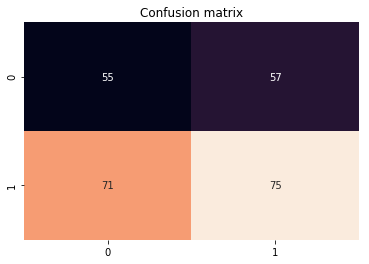

In [243]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

## Теперь его же но с tf-idf 

In [238]:
clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2), stop_words=stop_words)),
    ('tfidf', TfidfTransformer()),
    ('reducer', TruncatedSVD(n_components=30)),
    ('clf', RandomForestClassifier(random_state=0, n_estimators=100)),
])


clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['и', 'в', ...stimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False))])

In [239]:
predictions = clf.predict(X_test)

Precision:   0.56
Recall:   0.56
F1-measure:   0.56
Accuracy:   0.57
             precision    recall  f1-score   support

          0       0.51      0.46      0.49       112
          1       0.62      0.66      0.64       146

avg / total       0.57      0.57      0.57       258



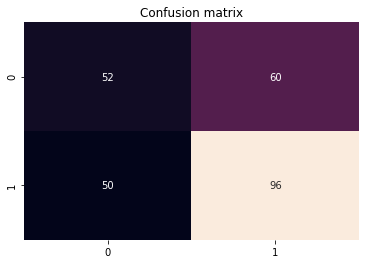

In [240]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))
labels = clf.classes_
sns.heatmap(data=confusion_matrix(y_test, predictions), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
plt.title("Confusion matrix")
plt.show()

### Выводы

Несмотря на то, что добавление tf-idf преобразования несколько улучшает общую точность предсказаний, сами результаты оставляют желать лучшего. Реузультаты MultinomialNB и LogisticRegression оказались хуже, чем у RandomForest.    

## Часть 3. Творческая
Придумайте и попытайтесь сделать еще что-нибудь, чтобы улучшить качество классификации. 
Направления развития:
* Морфологический признаки: 
    * использовать в качестве признаков только существительные или только именованные сущности;
* Модели скрытых тем:
    * использовать в качестве признаков скрытые темы;
    * использовать в качестве признаков динамические скрытые темы 
    пример тут: (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/dtm_example.ipynb)
* Синтаксические признаки:
    * использовать SOV-тройки в качестве признаков
    * кластеризовать SOV-тройки по эмбеддингам глаголов (обученные word2vec модели можно скачать отсюда: (http://rusvectores.org/ru/models/) и использовать только центроиды кластеров в качестве признаков
* что-нибудь еще     